# **Banking Client Segmentation using K-Medoids**

This notebook implements a **complete clustering pipeline** for **banking clients segmentation** using the **K-Medoids algorithm**.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply K-Medoids Clustering**
4. **Evaluate Clustering Performance**
5. **Visualize Results using t-SNE**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [2]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    df = data.drop(columns=['ID'])

# Display first 5 rows
df.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


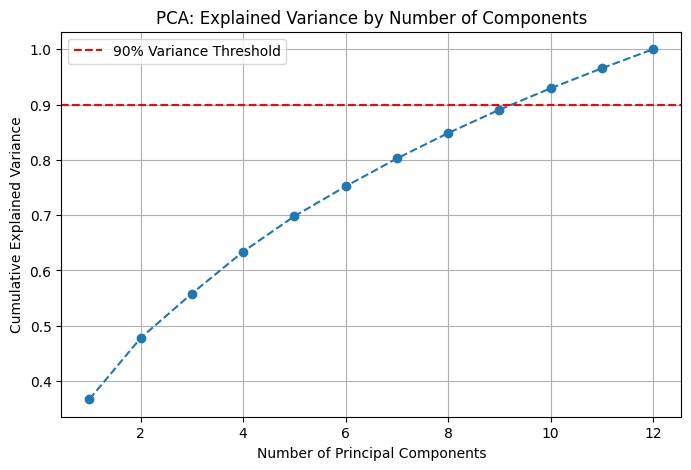

      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  1.657934  0.459028 -0.978825 -2.244287  0.877004 -0.263591 -1.029372   
1  4.789814 -0.072844 -0.382405  0.092595 -1.239877  0.126797  0.288586   
2  2.667048 -0.560942 -0.629649 -0.640127  0.154334 -0.740480 -1.097039   
3  0.046274  0.678199  0.659775  0.367287 -0.229333  0.162076  0.974848   
4  3.808080 -0.671991 -0.716316  0.418620  0.318433  0.595961  0.901428   

      PCA_8     PCA_9    PCA_10  ...  Job_2  Job_3  Job_4  Job_5  Area_2  \
0 -0.033418 -0.455660  1.264148  ...    0.0    0.0    0.0    0.0     1.0   
1 -0.279813  0.504755  0.204069  ...    1.0    0.0    0.0    0.0     1.0   
2  0.306435  0.204195 -0.842285  ...    1.0    0.0    0.0    0.0     0.0   
3  0.282434  0.207084 -0.004886  ...    1.0    0.0    0.0    0.0     0.0   
4  0.035986 -0.393837 -0.315179  ...    1.0    0.0    0.0    0.0     0.0   

   Area_3  CitySize_2  CitySize_3  Investments_2  Investments_3  
0     0.0         1.0     

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

# -------------------------
# 1. Data Preparation
# -------------------------
# Assume df is already loaded; create a working copy
df_cleaned = df.copy()

# Define categorical columns and identify numerical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

# Create copies for numerical and categorical features
numerical_features = df_cleaned[numerical_columns].copy()
categorical_features = df_cleaned[categorical_columns].copy()

# -------------------------
# 2. Winsorization & Correlation-based Feature Reduction
# -------------------------
# Apply winsorization (clipping extreme values at 1% on each tail)
for col in numerical_features.columns:
    numerical_features[col] = winsorize(numerical_features[col], limits=[0.01, 0.01])

# Compute correlation matrix on winsorized numerical features
corr_matrix = numerical_features.corr().abs()
# Use only the upper triangle of the correlation matrix to avoid duplicate pairs
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Identify features to drop if any correlation is greater than 0.85
features_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
# Drop highly correlated features
numerical_features_reduced = numerical_features.drop(columns=features_to_drop)

# -------------------------
# 3. Feature Scaling & PCA (for Numerical Features)
# -------------------------
# Scale the reduced numerical features and save the scaler for inverse transformation
scaler_num = StandardScaler()
X_num_scaled_reduced = scaler_num.fit_transform(numerical_features_reduced)

# Perform PCA on the scaled numerical features
# First, fit PCA on all components to examine the cumulative explained variance
pca_full = PCA()
pca_full.fit(X_num_scaled_reduced)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Determine the number of principal components needed to explain at least 90% variance
optimal_components = np.argmax(explained_variance >= 0.90) + 1

# Fit PCA with the optimal number of components and transform the data
pca_obj = PCA(n_components=optimal_components)
X_pca = pca_obj.fit_transform(X_num_scaled_reduced)

# Plot cumulative explained variance to visualize the optimal number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance by Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# 4. One-Hot Encoding (for Categorical Features)
# -------------------------
# Use OneHotEncoder (drop first to avoid multicollinearity)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(categorical_features)

# -------------------------
# 5. Combine Transformed Numerical and Categorical Features
# -------------------------
# Concatenate PCA-transformed numerical features and one-hot encoded categorical features
X_preprocessed = np.hstack((X_pca, X_cat))

# Create column names for PCA components and encoded categorical features
num_pca_components = X_pca.shape[1]
pca_col_names = [f'PCA_{i+1}' for i in range(num_pca_components)]
cat_col_names = encoder.get_feature_names_out(categorical_columns)

# Verify that the number of columns matches the expected count
expected_columns = np.concatenate((pca_col_names, cat_col_names))
if X_preprocessed.shape[1] != len(expected_columns):
    raise ValueError(f"Mismatch in column counts! Processed Data Shape: {X_preprocessed.shape}, Expected Columns: {len(expected_columns)}")

# Create a DataFrame with the processed data
preprocessed_df = pd.DataFrame(X_preprocessed, columns=expected_columns)
print(preprocessed_df.head())
print(f'Processed Data Shape: {X_preprocessed.shape}')

# -------------------------
# 6. Additional Feature Processing
# -------------------------
# Process additional numerical features for professional profiling and fine-education features
numerical_prof_columns = ['Income', 'Wealth', 'Debt', 'LifeStyle', 'Luxury', 'Age']
numerical_prof_features = df_cleaned[numerical_prof_columns].copy()
numerical_finedu_features = df_cleaned.drop(columns=categorical_columns + numerical_prof_columns)

# Create separate scalers for these groups to allow inverse transformation later
scaler_prof = StandardScaler()
X_num_prof = scaler_prof.fit_transform(numerical_prof_features)

scaler_finedu = StandardScaler()
X_num_finedu = scaler_finedu.fit_transform(numerical_finedu_features)

# -------------------------
# 7. Saving Transformation Objects
# -------------------------
# The following transformation objects are saved for later use in reconstructing the original features:
#   - scaler_num: Scaler for the reduced numerical features (used before PCA)
#   - pca_obj: PCA object to invert the PCA transformation
#   - encoder: OneHotEncoder for the categorical features
#   - scaler_prof and scaler_finedu: Scalers for the additional feature groups
#
# To reconstruct the original numerical features from a cluster center (or any transformed point):
#   1. Use pca_obj.inverse_transform() on the PCA portion of the center to recover the scaled numerical values.
#   2. Then, apply scaler_num.inverse_transform() to get back to the original winsorized numerical values.
#
# For categorical features, you might perform an argmax on the one-hot encoded sections to assign the category.

In [8]:
import gower
from scipy.spatial.distance import pdist, squareform

def hamming_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    """
    Combines Cityblock (Manhattan) distance for numerical features and 
    Hamming distance for categorical features using custom weights.
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')  # X_cat should be a dense binary array
    
    # Combine distances using the assigned weights
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)  # Return as a square distance matrix

def tanimoto_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    """
    Combines Cityblock (Manhattan) distance for numerical features and 
    Tanimoto (Jaccard) distance for binary categorical features using custom weights.
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard distance is equivalent to Tanimoto for binary features
    
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                            prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17):
    """
    Computes a custom distance matrix using Cityblock distance for two groups of numerical features 
    (professional and fine-education) and Hamming distance for categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                             prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17):
    """
    Computes a custom distance matrix using Cityblock distance for two groups of numerical features 
    (professional and fine-education) and Tanimoto (Jaccard) distance for binary categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard is equivalent to Tanimoto for binary features
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

# Create custom distance matrices using preprocessed data
hammingCityblock_distance = hamming_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)
tanimotoCityblock_distance = tanimoto_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)

# Create custom distance matrices using professional and fine-education features
hamming_dist_matrix_new = hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)
tanimoto_dist_matrix_new = tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)

# Compute additional distance matrices using different metrics
gower_distances = gower.gower_matrix(df)  # Consider using df_cleaned if preferred
euclidean_distances = squareform(pdist(X_preprocessed, metric='euclidean'))
manhattan_distances = squareform(pdist(X_preprocessed, metric='cityblock'))
cosine_distances = squareform(pdist(X_preprocessed, metric='cosine'))
chebyshev_distances = squareform(pdist(X_preprocessed, metric='chebyshev'))

# Display the first 5x5 section of each distance matrix
print("Hamming + Cityblock Distance (First 5x5):")
print(hammingCityblock_distance[:5, :5])

print("\nTanimoto + Cityblock Distance (First 5x5):")
print(tanimotoCityblock_distance[:5, :5])

print("\nHamming + Cityblock Distance new (First 5x5):")
print(hamming_dist_matrix_new[:5, :5])

print("\nTanimoto + Cityblock Distance new (First 5x5):")
print(tanimoto_dist_matrix_new[:5, :5])

print("\nGower Distance (First 5x5):")
print(gower_distances[:5, :5])

print("\nEuclidean Distance (First 5x5):")
print(euclidean_distances[:5, :5])

print("\nManhattan Distance (First 5x5):")
print(manhattan_distances[:5, :5])

print("\nCosine Distance (First 5x5):")
print(cosine_distances[:5, :5])

print("\nChebyshev Distance (First 5x5):")
print(chebyshev_distances[:5, :5])

Hamming + Cityblock Distance (First 5x5):
[[ 0.         10.27424242  7.54962875  9.75028169  9.76314741]
 [10.27424242  0.          6.96611734 11.29312826  5.40196   ]
 [ 7.54962875  6.96611734  0.          8.81453142  6.70778428]
 [ 9.75028169 11.29312826  8.81453142  0.         10.41841735]
 [ 9.76314741  5.40196     6.70778428 10.41841735  0.        ]]

Tanimoto + Cityblock Distance (First 5x5):
[[ 0.         10.36336898  7.677971    9.87862393  9.89683725]
 [10.36336898  0.          7.0552439  11.38480129  5.49108656]
 [ 7.677971    7.0552439   0.          8.90811431  6.83612653]
 [ 9.87862393 11.38480129  8.90811431  0.         10.51200024]
 [ 9.89683725  5.49108656  6.83612653 10.51200024  0.        ]]

Hamming + Cityblock Distance new (First 5x5):
[[0.         5.09749914 3.75561911 5.07292259 4.88170913]
 [5.09749914 0.         3.36522943 5.91402294 2.76992472]
 [3.75561911 3.36522943 0.         4.74732334 3.38975111]
 [5.07292259 5.91402294 4.74732334 0.         5.32498782]
 [4

In [9]:
from sklearn_extra.cluster import KMedoids


# Define number of clusters
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {
    "Gower": {},
    "Euclidean": {},
    "Manhattan": {},
    "Cosine": {},
    "Chebyshev": {},
    "Hamming + Cityblock": {},
    "Tanimoto + Cityblock": {},
    "Hamming + Cityblock new": {},
    "Tanimoto + Cityblock new": {}
}

# List of distance matrices
distance_matrices = {
    "Gower": gower_distances,
    "Euclidean": euclidean_distances,
    "Manhattan": manhattan_distances,
    "Cosine": cosine_distances,
    "Chebyshev": chebyshev_distances,
    "Hamming + Cityblock": hammingCityblock_distance,
    "Tanimoto + Cityblock": tanimotoCityblock_distance,
    "Hamming + Cityblock new": hamming_dist_matrix_new,
    "Tanimoto + Cityblock new": tanimoto_dist_matrix_new
}

for metric, dist_matrix in distance_matrices.items():
    print(f"\n🔹 Running K-Medoids for {metric} Distance\n")
    for k in k_values:
        print(f'Clustering with k={k}...')

        # Run K-Medoids
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, init='k-medoids++', max_iter=300)
        labels = kmedoids.fit_predict(dist_matrix)

        # Store results
        cluster_results[metric][k] = labels

print("✅ Clustering Completed for All Distance Metrics")


🔹 Running K-Medoids for Gower Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Euclidean Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Manhattan Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Cosine Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=1


🔹 Evaluating Clustering Performance for Gower Distance

🔹 Evaluating Clustering Performance for Euclidean Distance

🔹 Evaluating Clustering Performance for Manhattan Distance

🔹 Evaluating Clustering Performance for Cosine Distance

🔹 Evaluating Clustering Performance for Chebyshev Distance

🔹 Evaluating Clustering Performance for Hamming + Cityblock Distance

🔹 Evaluating Clustering Performance for Tanimoto + Cityblock Distance

🔹 Evaluating Clustering Performance for Hamming + Cityblock new Distance

🔹 Evaluating Clustering Performance for Tanimoto + Cityblock new Distance


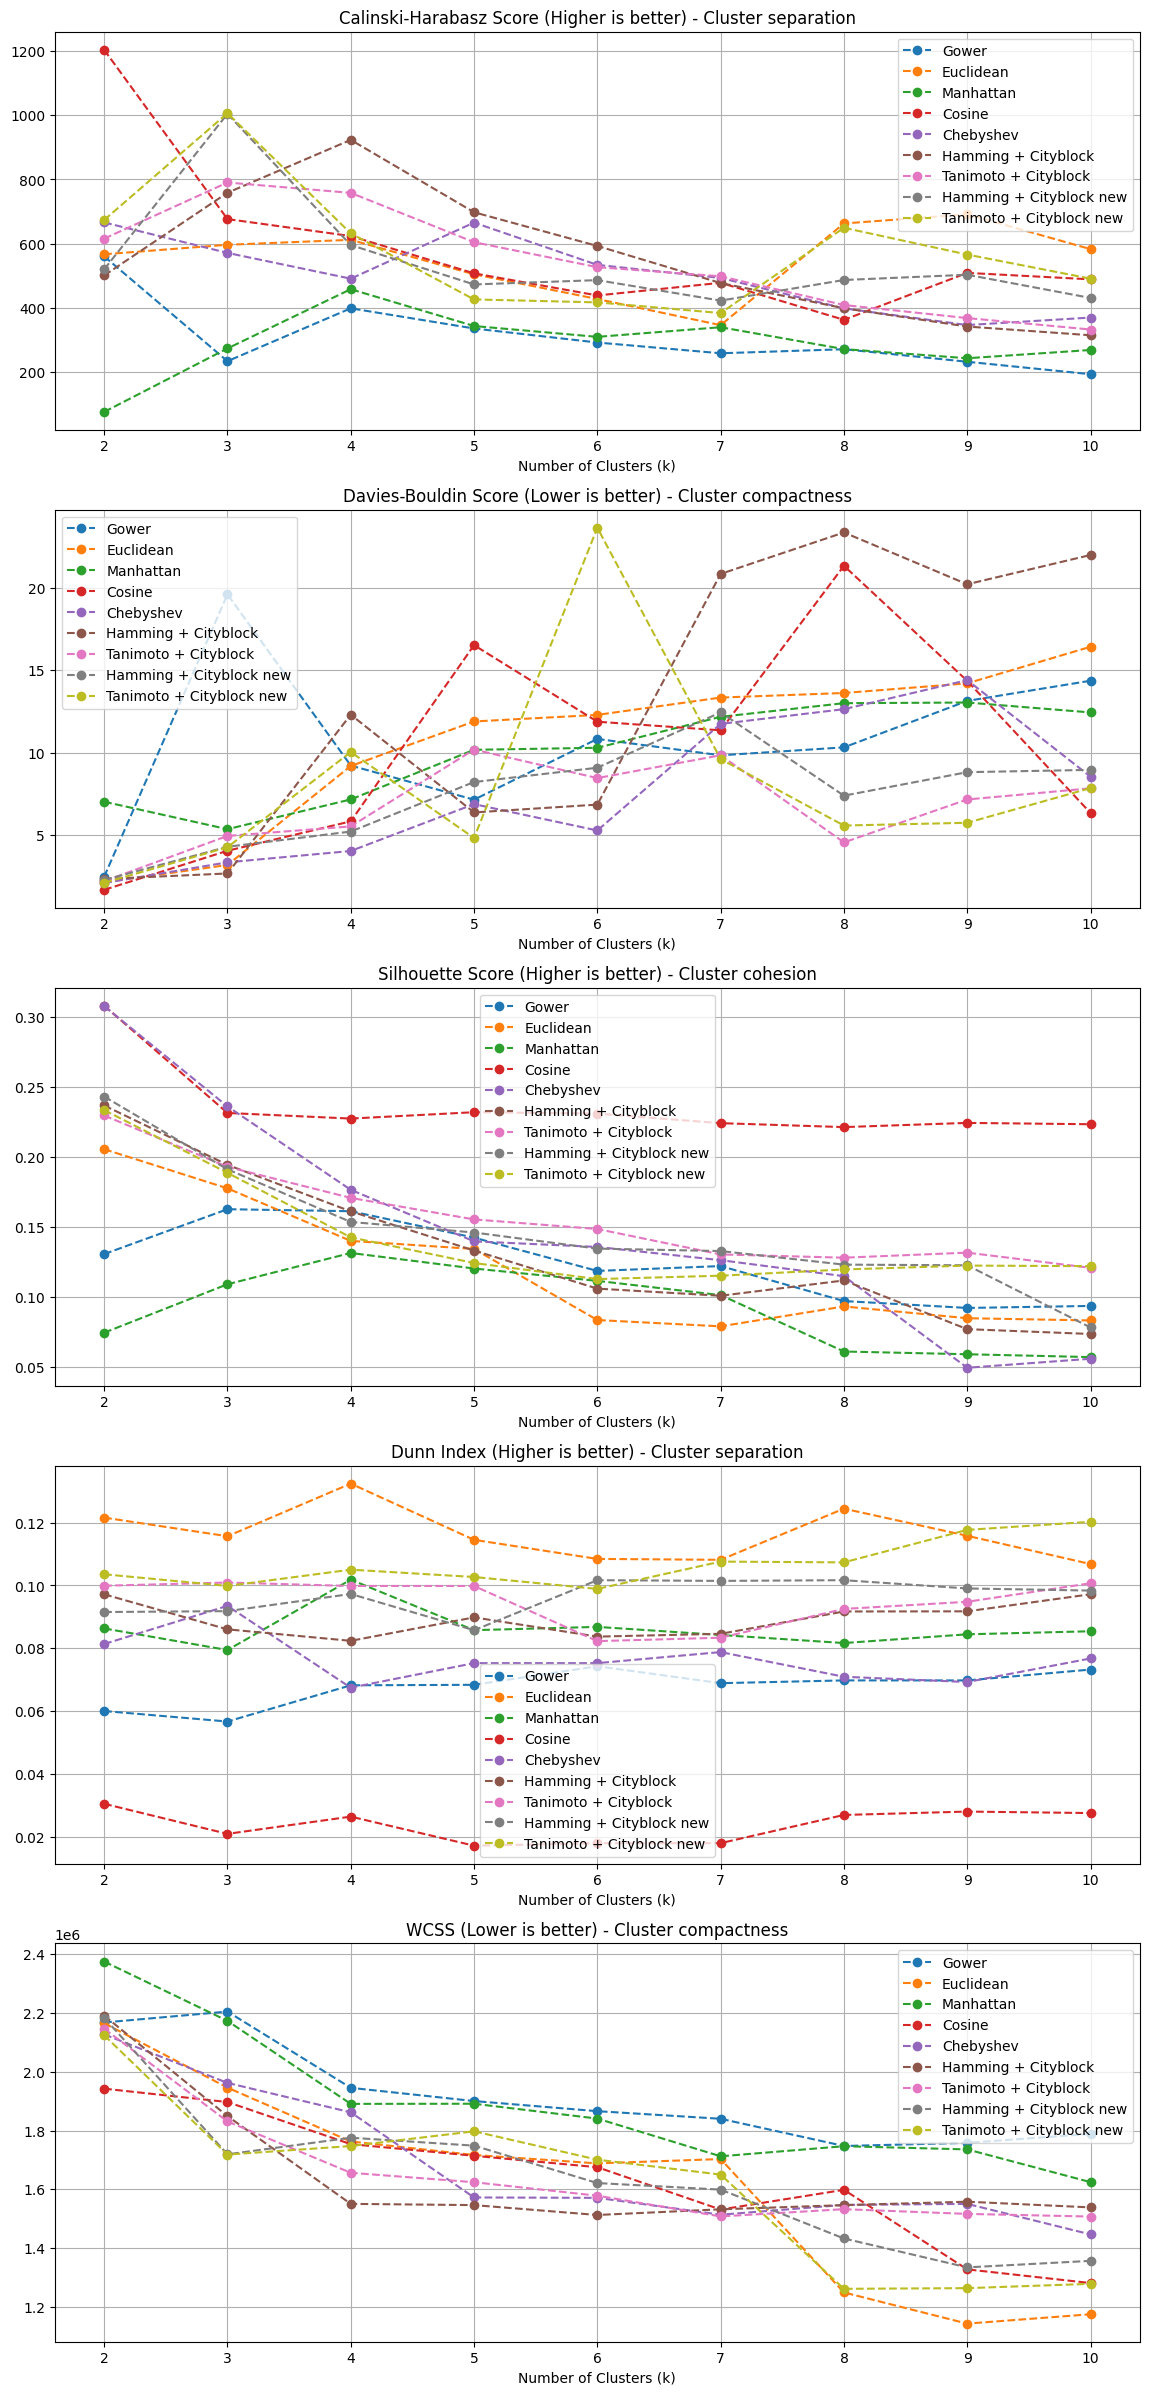


🔹 Best k values for Gower Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 3
✅ Optimal k (Dunn - Separation): 6
✅ Optimal k (WCSS - Compactness, Elbow Expected): 8

🔹 Best k values for Euclidean Distance:
✅ Optimal k (CH - Separation): 9
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 4
✅ Optimal k (WCSS - Compactness, Elbow Expected): 9

🔹 Best k values for Manhattan Distance:
✅ Optimal k (CH - Separation): 4
✅ Optimal k (DB - Compactness): 3
✅ Optimal k (Silhouette - Cohesion): 4
✅ Optimal k (Dunn - Separation): 4
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Cosine Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 2
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Chebyshev Distance:
✅ Optimal k (CH - Separation

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.spatial.distance import pdist

# Compute Dunn Index
def dunn_index(dist_matrix, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for cluster in unique_clusters:
        cluster_points = np.where(labels == cluster)[0]
        other_points = np.where(labels != cluster)[0]
        intra_dists.append(np.max(dist_matrix[np.ix_(cluster_points, cluster_points)]))
        inter_dists.append(np.min(dist_matrix[np.ix_(cluster_points, other_points)]))

    return np.min(inter_dists) / np.max(intra_dists)

# Compute WCSS (Within-Cluster Sum of Squares)
def compute_wcss(X, labels):
    unique_clusters = np.unique(labels)
    wcss = sum([
        np.nansum((X[labels == cluster] - np.nanmean(X[labels == cluster], axis=0)) ** 2)
        for cluster in unique_clusters
    ])
    return wcss

# Evaluate clustering for all distance metrics
def evaluate_clustering(X, cluster_results, distance_matrices):
    metrics = [
        "Gower", "Euclidean", "Manhattan", "Cosine", "Chebyshev",
        "Hamming + Cityblock", "Tanimoto + Cityblock",
        "Hamming + Cityblock new", "Tanimoto + Cityblock new"
    ]

    # Initialize scores dictionary for each metric
    scores = {metric: {"CH": [], "DB": [], "Silhouette": [], "Dunn": [], "WCSS": []} for metric in metrics}

    for metric in metrics:
        print(f"\n🔹 Evaluating Clustering Performance for {metric} Distance")
        # Use the k-values from this metric's results
        current_k_values = sorted(cluster_results[metric].keys())
        for k in current_k_values:
            labels = cluster_results[metric][k]
            distance_matrix = distance_matrices[metric]

            try:
                # Use X (passed to the function) instead of df directly
                scores[metric]["CH"].append(calinski_harabasz_score(X, labels))
                scores[metric]["DB"].append(davies_bouldin_score(X, labels))
                scores[metric]["Silhouette"].append(silhouette_score(distance_matrix, labels, metric='precomputed'))
                scores[metric]["Dunn"].append(dunn_index(distance_matrix, labels))
                scores[metric]["WCSS"].append(compute_wcss(X, labels))
            except ValueError as e:
                print(f"⚠️ Skipping k={k} for {metric} due to an error: {e}")
                scores[metric]["CH"].append(np.nan)
                scores[metric]["DB"].append(np.nan)
                scores[metric]["Silhouette"].append(np.nan)
                scores[metric]["Dunn"].append(np.nan)
                scores[metric]["WCSS"].append(np.nan)

    # Plot metrics for comparison
    fig, axes = plt.subplots(5, 1, figsize=(14, 30))  # Increased figure size for clarity
    metric_details = [
        ("Calinski-Harabasz Score (Higher is better) - Cluster separation", "CH"),
        ("Davies-Bouldin Score (Lower is better) - Cluster compactness", "DB"),
        ("Silhouette Score (Higher is better) - Cluster cohesion", "Silhouette"),
        ("Dunn Index (Higher is better) - Cluster separation", "Dunn"),
        ("WCSS (Lower is better) - Cluster compactness", "WCSS")
    ]

    for idx, (title, score_key) in enumerate(metric_details):
        for metric in metrics:
            current_k_values = sorted(cluster_results[metric].keys())
            valid_scores = np.array(scores[metric][score_key])
            valid_k_values = np.array(current_k_values)[~np.isnan(valid_scores)]
            valid_scores = valid_scores[~np.isnan(valid_scores)]
            axes[idx].plot(valid_k_values, valid_scores, marker='o', linestyle='--', label=metric)
        axes[idx].set_title(title)
        axes[idx].set_xlabel("Number of Clusters (k)")
        axes[idx].grid(True)
        axes[idx].legend(loc='best', fontsize=10)

    plt.show()

    # Find and print the best k for each distance metric
    for metric in metrics:
        current_k_values = sorted(cluster_results[metric].keys())
        ch_scores = np.array(scores[metric]['CH'])
        db_scores = np.array(scores[metric]['DB'])
        silhouette_scores = np.array(scores[metric]['Silhouette'])
        dunn_scores = np.array(scores[metric]['Dunn'])
        wcss_scores = np.array(scores[metric]['WCSS'])
        print(f"\n🔹 Best k values for {metric} Distance:")
        print(f"✅ Optimal k (CH - Separation): {current_k_values[np.argmax(ch_scores)]}")
        print(f"✅ Optimal k (DB - Compactness): {current_k_values[np.argmin(db_scores)]}")
        print(f"✅ Optimal k (Silhouette - Cohesion): {current_k_values[np.argmax(silhouette_scores)]}")
        print(f"✅ Optimal k (Dunn - Separation): {current_k_values[np.argmax(dunn_scores)]}")
        print(f"✅ Optimal k (WCSS - Compactness, Elbow Expected): {current_k_values[np.argmin(wcss_scores)]}")

    return scores

# Example call (ensure that X corresponds to the data on which you want to evaluate clustering)
clustering_scores = evaluate_clustering(df, cluster_results, distance_matrices)

In [12]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Use Euclidean distance with 4 clusters
distance_metric = "Tanimoto + Cityblock new"
num_clusters = 3
perplexity_value = 50

dist_matrix = distance_matrices[distance_metric]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    raise ValueError(f"⚠️ {distance_metric} distance matrix contains NaN or Inf values. Check your preprocessing!")

if dist_matrix.shape[0] != dist_matrix.shape[1]:
    raise ValueError(f"⚠️ {distance_metric} distance matrix must be square (NxN).")

# Check if the selected number of clusters exists
if num_clusters not in cluster_results[distance_metric]:
    raise ValueError(f"⚠️ num_clusters={num_clusters} is not in cluster_results[{distance_metric}]. Check clustering output!")

labels = cluster_results[distance_metric][num_clusters]

# Compute 3D t-SNE projection
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42, perplexity=perplexity_value)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels})

# Generate interactive 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df_plot['x'],
        y=df_plot['y'],
        z=df_plot['z'],
        mode='markers',
        marker=dict(
            size=5,  # Explicitly setting the size
            color=df_plot['Cluster'],  # Color by cluster
            colorscale='Turbo',  # Set color scale
            opacity=0.7  # Adjust transparency
        )
    )
])

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization ({distance_metric} Distance, k={num_clusters})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=800,  # Adjusted figure width
    height=800   # Adjusted figure height
)

fig.show()

In [13]:
import pandas as pd
from IPython.display import display
import numpy as np

# Ensure OneHotEncoder is fitted before retrieving feature names
if not hasattr(encoder, 'get_feature_names_out'):
    raise ValueError("⚠️ Encoder is not fitted. Ensure OneHotEncoder is properly trained before extracting feature names.")

# Get the actual feature names from OneHotEncoder (using the original categorical columns)
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
# Names for PCA-transformed numerical features
numerical_feature_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
all_feature_names = numerical_feature_names + list(encoded_feature_names)

# Auto-adjust feature name list if mismatched
if len(all_feature_names) != X_preprocessed.shape[1]:
    print(f"⚠️ Adjusting feature names dynamically: {len(all_feature_names)} names vs {X_preprocessed.shape[1]} columns.")
    all_feature_names = all_feature_names[:X_preprocessed.shape[1]]

# Convert preprocessed data back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute the mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Make a copy for original scale reconstruction
summary_original_scale = summary.copy()

# Inverse transform numerical features:
# First, invert PCA (from PCA space back to scaled numerical space),
# then invert scaling (from scaled space back to original numerical values).
# (Assumes scaler_num and pca_obj are your fitted StandardScaler and PCA objects, 
#  and that numerical_features_reduced.columns contains the original numerical feature names.)
if len(numerical_feature_names) == X_pca.shape[1]:
    try:
        # Inverse PCA transformation
        inv_scaled = pca_obj.inverse_transform(summary[numerical_feature_names])
        # Inverse scaling transformation
        original_numerical = scaler_num.inverse_transform(inv_scaled)
        # Create a DataFrame with the original numerical feature names
        original_numerical_df = pd.DataFrame(original_numerical, index=summary.index, columns=numerical_features_reduced.columns)
        # Remove the PCA component columns and add the original numerical columns
        summary_original_scale.drop(columns=numerical_feature_names, inplace=True, errors='ignore')
        summary_original_scale = pd.concat([summary_original_scale, original_numerical_df], axis=1)
        # Optionally clip unrealistic values (for example, if 'Age' is one of the features)
        if 'Age' in summary_original_scale.columns:
            summary_original_scale['Age'] = summary_original_scale['Age'].clip(lower=18, upper=100)
    except ValueError as e:
        print(f"⚠️ Error in inverse transformation: {e}. Skipping numerical rescaling.")

# Decode categorical features:
# For each categorical variable, select the dummy column with the highest mean value,
# and then extract the original category name.
try:
    categorical_decoded = pd.DataFrame(index=summary.index, columns=categorical_columns)
    for feature in categorical_columns:
        # Get columns corresponding to this feature (expected format: feature_category)
        feature_cols = [col for col in encoded_feature_names if col.startswith(feature + '_')]
        # For each cluster, select the category with the highest average value
        categorical_decoded[feature] = summary[feature_cols].idxmax(axis=1).str.replace(feature + '_', '')
    # Add the decoded categorical columns to the reconstructed DataFrame
    summary_original_scale = pd.concat([summary_original_scale, categorical_decoded], axis=1)
    # Optionally, drop the original one-hot encoded columns if present
    summary_original_scale.drop(columns=list(encoded_feature_names), inplace=True, errors='ignore')
except Exception as e:
    print(f"⚠️ Error decoding categorical values: {e}")

# Display the reconstructed cluster characteristics
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)

🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,,,
0,49.341780,2.072630,0.772857,0.782274,0.556416,0.718270,0.688204,0.757583,0.745397,0.697010,0.747273,0.600204,1,2,2,3,3
1,78.344215,2.344784,0.412482,0.422864,0.213471,0.370106,0.584897,0.342148,0.610347,0.280163,0.277518,0.386840,1,5,2,2,2
2,54.978145,2.789195,0.577638,0.573619,0.498634,0.493440,0.537886,0.526135,0.560588,0.456446,0.459469,0.564491,1,2,2,2,3
